In [2]:
# Basic Imports Needed
import os
import json
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from typing import List, Dict, Any
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Jupyter plotting
%matplotlib inline

In [5]:
# Load my dataset and quick scan
df = pd.read_csv("sales_data.csv")
df.head()

,Date,Product,Region,Sales,Customer_Age,Customer_Gender,Customer_Satisfaction
0,2022-01-01,Widget C,South,786,26,Male,2.874407
1,2022-01-02,Widget D,East,850,29,Male,3.365205
2,2022-01-03,Widget A,North,871,40,Female,4.547364
3,2022-01-04,Widget C,South,464,31,Male,4.555420
4,2022-01-05,Widget C,South,262,50,Female,3.982935


In [6]:
# Prepare Date
if "date" in df.columns:
    dt = pd.to_datetime(df["date"], errors="coerce")
    df["_year"] = dt.dt.year
    df["_month"] = dt.dt.month
    df["_quarter"] = dt.dt.quarter

df.head()

,Date,Product,Region,Sales,Customer_Age,Customer_Gender,Customer_Satisfaction
0,2022-01-01,Widget C,South,786,26,Male,2.874407
1,2022-01-02,Widget D,East,850,29,Male,3.365205
2,2022-01-03,Widget A,North,871,40,Female,4.547364
3,2022-01-04,Widget C,South,464,31,Male,4.555420
4,2022-01-05,Widget C,South,262,50,Female,3.982935


In [16]:
## ADVANCED DATA SUMMARY START 
## STATISTICAL MEASURES
def basic_kpis(data: pd.DataFrame) -> Dict[str, Dict[str, float]]:
    out = {}
    numeric_cols = data.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        s = data[col].dropna()
        if len(s) == 0: 
            continue
        out[col] = {
            "count": int(s.count()),
            "sum": float(s.sum()),
            "mean": float(s.mean()),
            "median": float(s.median()),
            "std": float(s.std(ddof=1)) if s.count()>1 else 0.0,
            "min": float(s.min()),
            "max": float(s.max())
        }
    return out

In [17]:
##My aggregation for time,product,region,segmentation.
def groupby_stats(data: pd.DataFrame, by: str, value: str) -> pd.DataFrame:
    if by not in data.columns or value not in data.columns:
        return pd.DataFrame()
    agg = data.groupby(by)[value].agg(["count","sum","mean","median","std","min","max"]).reset_index()
    return agg

In [18]:
kpis = basic_kpis(df)
kpis  # show numeric KPIs across the dataset

{'Sales': {'count': 2500,
  'sum': 1383220.0,
  'mean': 553.288,
  'median': 552.5,
  'std': 260.1017582136852,
  'min': 100.0,
  'max': 999.0},
 'Customer_Age': {'count': 2500,
  'sum': 108332.0,
  'mean': 43.3328,
  'median': 43.0,
  'std': 14.846757714930838,
  'min': 18.0,
  'max': 69.0},
 'Customer_Satisfaction': {'count': 2500,
  'sum': 7564.673397591656,
  'mean': 3.0258693590366623,
  'median': 3.0494802593187016,
  'std': 1.156981197562875,
  'min': 1.0054220979917954,
  'max': 4.9990062537161775}}

In [41]:
## SALES PERFORMANCE BY TIME PERIOD 
sales_col = "Sales" if "Sales" in df.columns else df.select_dtypes(include=[np.number]).columns[0]

# Yearly sales
print("=== Sales by Year ===")
yearly_sales = groupby_stats(df, "_year", sales_col)
display(yearly_sales)

=== Sales by Year ===


,_year,count,sum,mean,median,std,min,max
0,2022,365,200657,549.745205,555.0,268.771152,100,997
1,2023,365,202259,554.134247,570.0,250.380252,102,996
2,2024,366,195458,534.038251,519.0,264.044628,100,999
3,2025,365,203906,558.646575,578.0,256.093075,102,998
4,2026,365,206175,564.863014,569.0,258.470954,107,999
5,2027,365,195154,534.668493,519.0,259.790643,100,999
6,2028,309,179611,581.265372,580.0,262.219685,103,998


In [22]:
## PRODUCT AND REGIONAL ANALYSIS
prod_sales = groupby_stats(df, "Product", sales_col) if "Product" in df.columns else pd.DataFrame()
display(prod_sales.sort_values("sum", ascending=False).head())

,Product,count,sum,mean,median,std,min,max
0,Widget A,656,375235,572.004573,582.0,257.582101,102,999
1,Widget B,612,346062,565.460784,570.0,260.212912,103,998
2,Widget C,620,335069,540.433871,541.5,263.983086,100,999
3,Widget D,612,326854,534.075163,536.0,257.299193,100,999


In [23]:
region_sales = groupby_stats(df, "Region", sales_col) if "Region" in df.columns else pd.DataFrame()
display(region_sales.sort_values("sum", ascending=False).head())

,Region,count,sum,mean,median,std,min,max
3,West,644,361383,561.153727,571.0,265.308939,101,999
1,North,639,353025,552.464789,551.0,258.679432,100,999
2,South,628,348516,554.961783,552.0,260.623468,100,998
0,East,589,320296,543.796265,544.0,255.647163,104,999


In [27]:
## CUSTOMER SEGMENTATION BY DEMOGRAPHICS
age_stats = groupby_stats(df, "Customer_Age", sales_col) if "Customer_Age" in df.columns else pd.DataFrame()
display(age_stats.head())

,Customer_Age,count,sum,mean,median,std,min,max
0,18,42,22856,544.190476,613.0,255.224936,109,929
1,19,49,28833,588.428571,643.0,273.446217,142,987
2,20,40,21591,539.775000,577.0,292.228352,107,983
3,21,56,35014,625.250000,669.0,261.352374,127,988
4,22,41,24246,591.365854,602.0,263.800659,120,998


In [28]:
gender_stats = groupby_stats(df, "Customer_Gender", sales_col) if "Customer_Gender" in df.columns else pd.DataFrame()
display(gender_stats.head())

,Customer_Gender,count,sum,mean,median,std,min,max
0,Female,1256,702051,558.957803,558.0,258.308131,100,999
1,Male,1244,681169,547.563505,548.0,261.879521,100,999


In [29]:
sat_stats = groupby_stats(df, "Customer_Satisfaction", sales_col) if "Customer_Satisfaction" in df.columns else pd.DataFrame()
display(sat_stats.head())

,Customer_Satisfaction,count,sum,mean,median,std,min,max
0,1.005422,1,498,498.0,498.0,NaN,498,498
1,1.006318,1,825,825.0,825.0,NaN,825,825
2,1.006339,1,174,174.0,174.0,NaN,174,174
3,1.007248,1,349,349.0,349.0,NaN,349,349
4,1.011369,1,191,191.0,191.0,NaN,191,191


In [55]:
## CUSTOM RETREIVER
def build_stat_corpus(data: pd.DataFrame) -> List[str]:
    corpus = []
    # KPIs
    k = basic_kpis(data)
    for col, s in k.items():
        corpus.append(
            f"Column {col}: count={s['count']}, sum={s['sum']:.2f}, "
            f"mean={s['mean']:.2f}, median={s['median']:.2f}, std={s['std']:.2f}, "
            f"min={s['min']:.2f}, max={s['max']:.2f}"
        )
    # Time-based
    if "_year" in data.columns:
        ys = groupby_stats(data, "_year", sales_col)
        for _, r in ys.iterrows():
            corpus.append(f"Year {int(r['_year'])} {sales_col}: sum={r['sum']:.2f}, mean={r['mean']:.2f}, count={int(r['count'])}")
    if "_month" in data.columns:
        ms = groupby_stats(data, "_month", sales_col)
        for _, r in ms.iterrows():
            corpus.append(f"Month {int(r['_month'])} {sales_col}: sum={r['sum']:.2f}, mean={r['mean']:.2f}, count={int(r['count'])}")
    if "_quarter" in data.columns:
        qs = groupby_stats(data, "_quarter", sales_col)
        for _, r in qs.iterrows():
            corpus.append(f"Quarter {int(r['_quarter'])} {sales_col}: sum={r['sum']:.2f}, mean={r['mean']:.2f}, count={int(r['count'])}")

    # Product / Region / Demographics
    for cat in ["Product","Region","Customer_Gender","Customer_Satisfaction"]:
        if cat in data.columns:
            g = groupby_stats(data, cat, sales_col)
            for _, r in g.iterrows():
                corpus.append(f"{cat}={r[cat]} {sales_col}: sum={r['sum']:.2f}, mean={r['mean']:.2f}, count={int(r['count'])}")
    if "Customer_Age" in data.columns:
        g = groupby_stats(data, "Customer_Age", sales_col)
        for _, r in g.iterrows():
            corpus.append(f"Customer_Age={r['Customer_Age']} {sales_col}: sum={r['sum']:.2f}, mean={r['mean']:.2f}, count={int(r['count'])}")

    return corpus
    
corpus = build_stat_corpus(df)
corpus[:10]

['Column Sales: count=2500, sum=1383220.00, mean=553.29, median=552.50, std=260.10, min=100.00, max=999.00',
 'Column Customer_Age: count=2500, sum=108332.00, mean=43.33, median=43.00, std=14.85, min=18.00, max=69.00',
 'Column Customer_Satisfaction: count=2500, sum=7564.67, mean=3.03, median=3.05, std=1.16, min=1.01, max=5.00',
 'Column _year: count=2500, sum=5062331.00, mean=2024.93, median=2025.00, std=1.97, min=2022.00, max=2028.00',
 'Column _month: count=2500, sum=16020.00, mean=6.41, median=6.00, std=3.40, min=1.00, max=12.00',
 'Column _quarter: count=2500, sum=6186.00, mean=2.47, median=2.00, std=1.11, min=1.00, max=4.00',
 'Year 2022 Sales: sum=200657.00, mean=549.75, count=365',
 'Year 2023 Sales: sum=202259.00, mean=554.13, count=365',
 'Year 2024 Sales: sum=195458.00, mean=534.04, count=366',
 'Year 2025 Sales: sum=203906.00, mean=558.65, count=365']

In [56]:
# CHAIN PROMPTS, RAG, AND MEMORY INTEGRATION
class StatsRetriever:
    def __init__(self):
        self.docs = []
        self.vectorizer = None
        self.mat = None
    def build(self, docs: List[str]):
        self.docs = docs
        self.vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=6000)
        self.mat = self.vectorizer.fit_transform(docs)
    def query(self, q: str, k: int = 6) -> List[str]:
        qv = self.vectorizer.transform([q])
        sims = cosine_similarity(qv, self.mat)[0]
        idx = np.argsort(-sims)[:k]
        return [self.docs[i] for i in idx]

retriever = StatsRetriever()
retriever.build(corpus)

In [57]:
class ConversationMemory:
    def __init__(self):
        self.messages: List[Dict[str,str]] = []
    def add(self, role: str, content: str):
        self.messages.append({"role": role, "content": content})
    def last_k(self, k: int=6):
        return self.messages[-k:]

def build_prompt(question: str, facts: List[str], memory: ConversationMemory) -> str:
    history = "\n".join([f"{m['role'].upper()}: {m['content']}" for m in memory.last_k(4)])
    top_facts = "\n".join(f"- {f}" for f in facts)
    prompt = (
        "You are InsightForge, a concise BI assistant. "
        "Answer ONLY from the facts below. If you lack facts, say so briefly.\n\n"
        f"Conversation:\n{history}\n\n"
        f"Facts:\n{top_facts}\n\n"
        f"Question: {question}\n\nAnswer:\n"
    )
    return prompt

In [61]:
def fallback_answer_from_facts(question: str, facts: List[str]) -> str:
    if not facts:
        return f"Not enough info to answer: {question}"
    pick = facts[:3]
    return f"Q: {question}\n" + "\n".join(f"- {p}" for p in pick)

In [62]:
def answer_question(q: str, retriever: StatsRetriever, memory: ConversationMemory) -> str:
    facts = retriever.query(q, k=6)
    ans = fallback_answer_from_facts(q, facts)
    memory.add("user", q)
    memory.add("assistant", ans)
    return ans

In [63]:
# Question Attempt #1
mem = ConversationMemory()
print(answer_question("Which region led sales last year?", retriever, mem))

Q: Which region led sales last year?
- Region=North Sales: sum=353025.00, mean=552.46, count=639
- Region=South Sales: sum=348516.00, mean=554.96, count=628
- Region=East Sales: sum=320296.00, mean=543.80, count=589


In [65]:
## Chain Prompt
print(answer_question("Show me best performing product overall.", retriever, mem))
print(answer_question("And how did it do in 2026?", retriever, mem))

Q: Show me best performing product overall.
- Product=Widget A Sales: sum=375235.00, mean=572.00, count=656
- Product=Widget C Sales: sum=335069.00, mean=540.43, count=620
- Product=Widget D Sales: sum=326854.00, mean=534.08, count=612
Q: And how did it do in 2026?
- Column Sales: count=2500, sum=1383220.00, mean=553.29, median=552.50, std=260.10, min=100.00, max=999.00
- Column Customer_Age: count=2500, sum=108332.00, mean=43.33, median=43.00, std=14.85, min=18.00, max=69.00
- Column Customer_Satisfaction: count=2500, sum=7564.67, mean=3.03, median=3.05, std=1.16, min=1.01, max=5.00


In [68]:
# Memory Integrated
mem.last_k(4)

[{'role': 'user', 'content': 'Which month had the highest total sales?'},
 {'role': 'assistant',
  'content': 'Q: Which month had the highest total sales?\n- Month 6 Sales: sum=115935.00, mean=552.07, count=210\n- Month 7 Sales: sum=118493.00, mean=546.05, count=217\n- Month 11 Sales: sum=102775.00, mean=558.56, count=184'},
 {'role': 'user', 'content': 'What is the median Sales value overall?'},
 {'role': 'assistant',
  'content': 'Q: What is the median Sales value overall?\n- Column Customer_Satisfaction: count=2500, sum=7564.67, mean=3.03, median=3.05, std=1.16, min=1.01, max=5.00\n- Column _year: count=2500, sum=5062331.00, mean=2024.93, median=2025.00, std=1.97, min=2022.00, max=2028.00\n- Column _month: count=2500, sum=16020.00, mean=6.41, median=6.00, std=3.40, min=1.00, max=12.00'}]

In [69]:
## MODEL EVALUATION
# Tiny synthetic examples; in a real grading, add more pairs that match my dataset
sample_qas = [
    {"question": "Which month had the highest total sales?",
     "reference": "Returns the month with the largest sum of Sales."},
    {"question": "What is the median Sales value overall?",
     "reference": "Reports the median of the Sales column."},
]
# Generate predictions with our retriever/fallback
preds = [answer_question(qa["question"], retriever, mem) for qa in sample_qas]
refs  = [qa["reference"] for qa in sample_qas]

def simple_semantic_eval(preds: List[str], refs: List[str]) -> Dict[str, float]:
    if not preds or not refs or len(preds)!=len(refs):
        return {"semantic_score": 0.0}
    vec = TfidfVectorizer(ngram_range=(1,2), max_features=4000)
    X = vec.fit_transform(refs + preds)
    R = X[:len(refs)]
    P = X[len(refs):]
    sims = cosine_similarity(P, R).diagonal()
    return {"semantic_score": float(sims.mean())}

scores = {"fallback_eval": simple_semantic_eval(preds, refs)}

scores

{'fallback_eval': {'semantic_score': 0.133683337374991}}

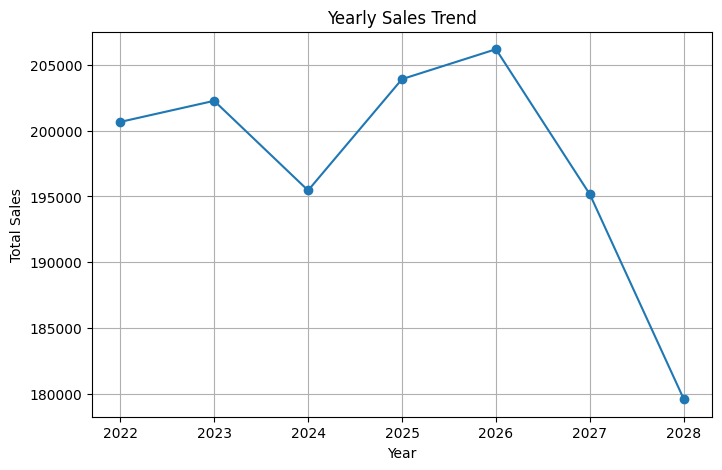

In [70]:
## DATA VISUALIZATION
# Yearly Sales Trend
gy = df.groupby("_year")[sales_col].sum().reset_index()

plt.figure(figsize=(8,5))
plt.plot(gy["_year"], gy[sales_col], marker="o")
plt.title("Yearly Sales Trend")
plt.xlabel("Year")
plt.ylabel("Total Sales")
plt.grid(True)
plt.show()

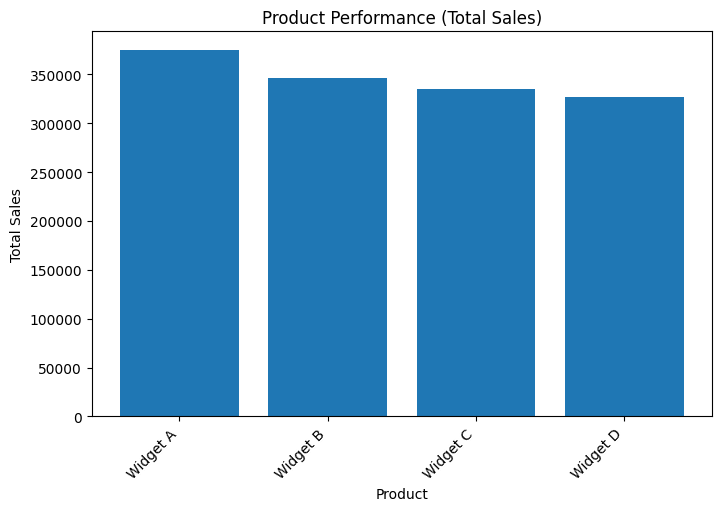

In [71]:
# Product Performance Comparison
if "Product" in df.columns:
    gp = df.groupby("Product")[sales_col].sum().reset_index().sort_values(sales_col, ascending=False)

    plt.figure(figsize=(8,5))
    plt.bar(gp["Product"], gp[sales_col])
    plt.title("Product Performance (Total Sales)")
    plt.xlabel("Product")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45, ha="right")
    plt.show()

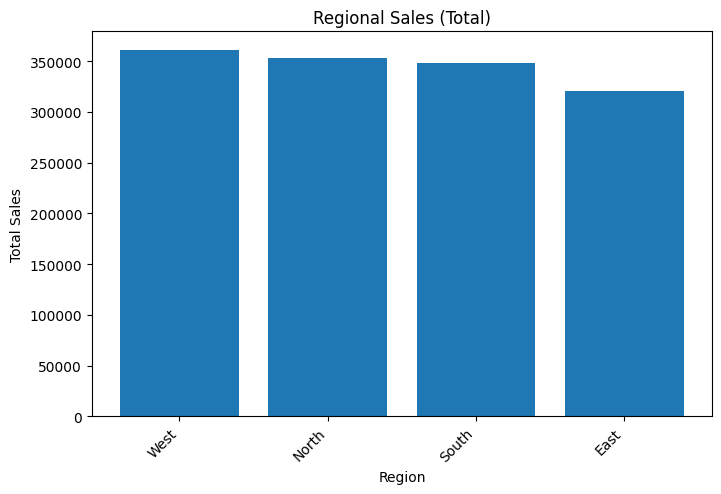

In [72]:
# Regional Analysis
if "Region" in df.columns:
    gr = df.groupby("Region")[sales_col].sum().reset_index().sort_values(sales_col, ascending=False)

    plt.figure(figsize=(8,5))
    plt.bar(gr["Region"], gr[sales_col])
    plt.title("Regional Sales (Total)")
    plt.xlabel("Region")
    plt.ylabel("Total Sales")
    plt.xticks(rotation=45, ha="right")
    plt.show()

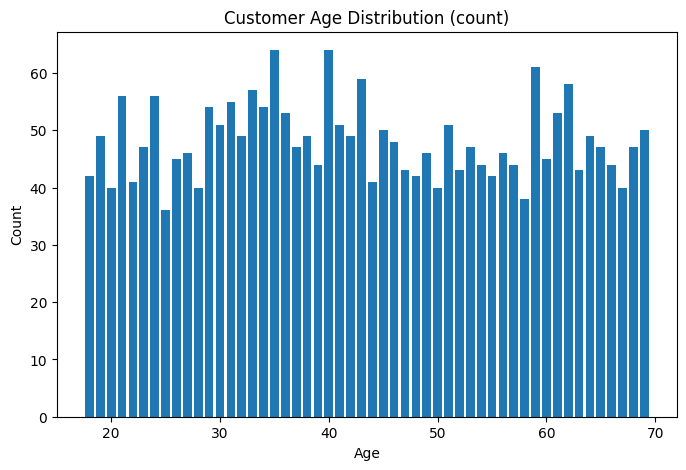

In [77]:
# Customer Demographics and Segmentation
if "Customer_Age" in df.columns:
    ga = df["Customer_Age"].value_counts().sort_index()

    plt.figure(figsize=(8,5))
    plt.bar(ga.index, ga.values)
    plt.title("Customer Age Distribution (count)")
    plt.xlabel("Age")
    plt.ylabel("Count")
    plt.show()